## Main

In [18]:
import numpy as np
import pandas as pd
from enum import IntEnum
from tqdm import tqdm
import csv
import matplotlib.pyplot as plt

### Data Preprocessing

In [19]:
class PM2_5:
    def __init__(self, mode):
        self.file_path = 'train.csv' if mode == 'train' else 'test.csv'
        self.mode = mode
        self.x = np.array([0])
        self.y = np.array([0])

        # preprocessing data (get rid of unimportant data)
        if mode == 'train':
            df = pd.read_csv(self.file_path)
        else:
            df = pd.read_csv(self.file_path, header=None)
            df.columns = ['Location', 'ItemName', '0', '1', '2', '3', '4', '5', '6', '7', '8']

        for col in df.columns:
            if not col.isnumeric():
                df = df.drop(col, axis='columns')
        df.replace('[#*xA\s]', np.nan, inplace=True, regex = True)  # replace invalid data with np.nan
        df = df.astype(float)

        # handling invalid data (replace invalid data by mean value)
        self.nparray = df.to_numpy()
        for i in range(self.nparray.shape[0]):
            for j in range(self.nparray.shape[1]):
                if np.isnan(self.nparray[i][j]):
                    self.nparray[i][j] = np.nanmean(self.nparray[i])

    # get data by choosen features (the wanted item should be chosed)
    def pred_by_features(self, feature_idx):
        # initialize
        self.x = np.zeros((1, len(feature_idx), 9))
        self.y = np.zeros((1, len(feature_idx)))
        
        for i in range(0, self.nparray.shape[0], 18):
            # training data
            if self.mode == 'train':
                for j in range(self.nparray.shape[1]-9):
                    x_rows = [[self.nparray[i+k, j:j+9]] for k in feature_idx]  # get 9 hours data for all choosen features
                    x_data = [np.concatenate(x_rows, axis=0)]
                    y_rows = [[self.nparray[i+k, j+9]] for k in feature_idx]    # get the corresponding value for all choosen features
                    y_data = [np.concatenate(y_rows, axis=0)]
                    if not np.any(np.isnan(x_data)) and not np.any(np.isnan(y_data)):
                        self.x = np.append(self.x, x_data, axis=0)
                        self.y = np.append(self.y, y_data, axis=0)
            # testing data (no ground truth value)
            else:
                x_rows = [[self.nparray[i+k]] for k in feature_idx]
                x_data = [np.concatenate(x_rows, axis=0)]
                if not np.any(np.isnan(x_data)):
                    self.x = np.append(self.x, x_data, axis=0)

        if self.mode == 'train':
            return self.x, self.y
        else:
            return self.x

In [21]:
# define feature idx for futher use
class Item(IntEnum):
    AMB_TEMP = 0
    CH4 = 1
    CO = 2
    NMHC = 3
    NO = 4
    NO2 = 5
    NOx = 6
    O3 = 7
    PM10 = 8
    PM2_5 = 9
    RAINFALL = 10
    RH = 11
    SO2 = 12
    THC = 13
    WD_HR = 14
    WIND_DIREC = 15
    WIND_SPEED = 16
    WS_HR = 17

### Linear Regression Model

In [30]:
class LinearRegression:
    def __init__(self, learning_rate=0.1, n_iterations=1000, alpha = 0):
        self.weights = None
        self.bias = None
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.alpha = alpha  # L2 regularization (default: don't use)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for i in tqdm(range(self.n_iterations)):
            y_pred = X @ self.weights + self.bias
            error = y_pred - y

            # calculating gradient
            dw = (2 / n_samples) * (X.T @ error + self.alpha * self.weights)
            db = (2 / n_samples) * np.sum(error)

            # update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        if self.weights is None or self.bias is None:
            raise ValueError("Model has not been trained yet.")
        return X @ self.weights + self.bias
        
    def initialize(self):
        self.weights = None
        self.bias = None

### Start Training and Evaluation

In [ ]:
choosen_features = [item for item in Item if item != Item.SO2]  # use 17 features to predict pm2.5 value
# choosen_features = [Item.PM10, Item.PM2_5, Item.CO]  # 3 features

In [ ]:
# getting data
train_dataset = PM2_5('train')
test_dataset = PM2_5('test')
X_train, y_train = train_dataset.pred_by_features(choosen_features)
X_test = test_dataset.pred_by_features(choosen_features)

# drop the initialization value
X_train = np.delete(X_train, np.s_[0], axis=0)
y_train = np.delete(y_train, np.s_[0], axis=0)
X_test = np.delete(X_test, np.s_[0], axis=0)

In [ ]:
# reshape data for fitting the input shape of linear regression
n_train, dim1, dim2 = X_train.shape
n_test, dim1, dim2 = X_test.shape

X_train = X_train.reshape(n_train * dim1, dim2)
y_train = y_train.reshape(n_train * dim1)
X_test = X_test.reshape(n_test * dim1, dim2)

In [ ]:
# training
model = LinearRegression(learning_rate=2e-5, n_iterations=10000)
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

with open('submission.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['index', 'answer'])
    j = 0
    for i in range(choosen_features.index(Item.PM2_5), y_pred.shape[0], len(choosen_features)):
        writer.writerow([f'index_{j}', f'{y_pred[i]:.2f}'])
        j += 1 

## Experiments

### Effect of Type of Training Data on Prediction Accuracy

/tmp/ipykernel_889965/1850177894.py:26: RuntimeWarning: Mean of empty slice
  self.nparray[i][j] = np.nanmean(self.nparray[i])
/tmp/ipykernel_889965/1850177894.py:26: RuntimeWarning: Mean of empty slice
  self.nparray[i][j] = np.nanmean(self.nparray[i])
100%|██████████| 10000/10000 [00:03<00:00, 3140.60it/s]
/tmp/ipykernel_889965/1850177894.py:26: RuntimeWarning: Mean of empty slice
  self.nparray[i][j] = np.nanmean(self.nparray[i])


=> 3correlated data rmse: 4.233001965598413



/tmp/ipykernel_889965/1850177894.py:26: RuntimeWarning: Mean of empty slice
  self.nparray[i][j] = np.nanmean(self.nparray[i])
100%|██████████| 10000/10000 [00:04<00:00, 2256.81it/s]
/tmp/ipykernel_889965/1850177894.py:26: RuntimeWarning: Mean of empty slice
  self.nparray[i][j] = np.nanmean(self.nparray[i])


=> 4correlated data rmse: 4.854093312678262



/tmp/ipykernel_889965/1850177894.py:26: RuntimeWarning: Mean of empty slice
  self.nparray[i][j] = np.nanmean(self.nparray[i])
100%|██████████| 10000/10000 [00:03<00:00, 3015.74it/s]
/tmp/ipykernel_889965/1850177894.py:26: RuntimeWarning: Mean of empty slice
  self.nparray[i][j] = np.nanmean(self.nparray[i])


=> factor data rmse: 3.2400553944725976



/tmp/ipykernel_889965/1850177894.py:26: RuntimeWarning: Mean of empty slice
  self.nparray[i][j] = np.nanmean(self.nparray[i])
100%|██████████| 10000/10000 [07:15<00:00, 22.98it/s]


=> all data rmse: 21.917131479119675



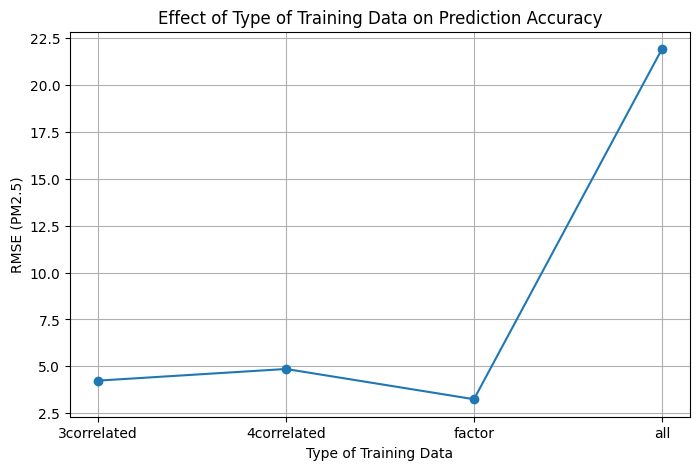

In [27]:
errors = []

# initialize datasets
choosen_features_list = [[Item.PM2_5, Item.PM10, Item.NO2, Item.CO],            # top 3 highly linear correlated
                         [Item.PM2_5, Item.PM10, Item.NO2, Item.CO, Item.O3],   # top 4 highly linear correlated
                         [Item.PM2_5, Item.WIND_SPEED, Item.RH, Item.NO2],      # factors influencing variation
                         [item for item in Item if item != Item.SO2]]           # all features except for SO2
save_name_list = ['3correlated','4correlated', 'factor', 'all']


# start experiment
for choosen_features, save_name in zip(choosen_features_list, save_name_list):
    # initialize data
    train_dataset = PM2_5('train')
    test_dataset = PM2_5('test')
    X_train, y_train = train_dataset.pred_by_features(choosen_features)
    X_test = test_dataset.pred_by_features(choosen_features)

    X_train = np.delete(X_train, np.s_[0], axis=0)
    y_train = np.delete(y_train, np.s_[0], axis=0)
    X_test = np.delete(X_test, np.s_[0], axis=0)

    n_train, dim1, dim2 = X_train.shape
    n_test, dim1, dim2 = X_test.shape

    X_train = X_train.reshape(n_train * dim1, dim2)
    y_train = y_train.reshape(n_train * dim1)
    X_test = X_test.reshape(n_test * dim1, dim2)
    
    # start training
    model = LinearRegression(learning_rate=2e-5, n_iterations=10000)
    model.initialize()
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    rmse = np.sqrt(np.mean((y_train - y_pred_train) ** 2))
    errors.append(rmse)
    print(f'=> {save_name} data rmse: {rmse}\n')

    y_pred = model.predict(X_test)

    with open(f'submission_{save_name}.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['index', 'answer'])
        j = 0
        for i in range(choosen_features.index(Item.PM2_5), y_pred.shape[0], len(choosen_features)):
            writer.writerow([f'index_{j}', f'{y_pred[i]:.2f}'])
            j += 1 

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(save_name_list, errors, marker='o', linestyle='-')
plt.xlabel("Type of Training Data")
plt.ylabel("RMSE (PM2.5)")
plt.title("Effect of Type of Training Data on Prediction Accuracy")
plt.grid()
plt.show()


### Effect of Training Data Size on Prediction Accuracy

/tmp/ipykernel_889965/1850177894.py:26: RuntimeWarning: Mean of empty slice
  self.nparray[i][j] = np.nanmean(self.nparray[i])
/tmp/ipykernel_889965/1850177894.py:26: RuntimeWarning: Mean of empty slice
  self.nparray[i][j] = np.nanmean(self.nparray[i])
100%|██████████| 10000/10000 [00:00<00:00, 30005.27it/s]


=> 10% data size rmse: 4.695904430811767



100%|██████████| 10000/10000 [00:00<00:00, 17300.02it/s]


=> 25% data size rmse: 5.245328931418931



100%|██████████| 10000/10000 [00:00<00:00, 10722.26it/s]


=> 50% data size rmse: 4.632804601840904



100%|██████████| 10000/10000 [00:01<00:00, 7215.22it/s]


=> 75% data size rmse: 4.2363555656404035



100%|██████████| 10000/10000 [00:02<00:00, 4599.93it/s]


=> 100% data size rmse: 4.233001965598413



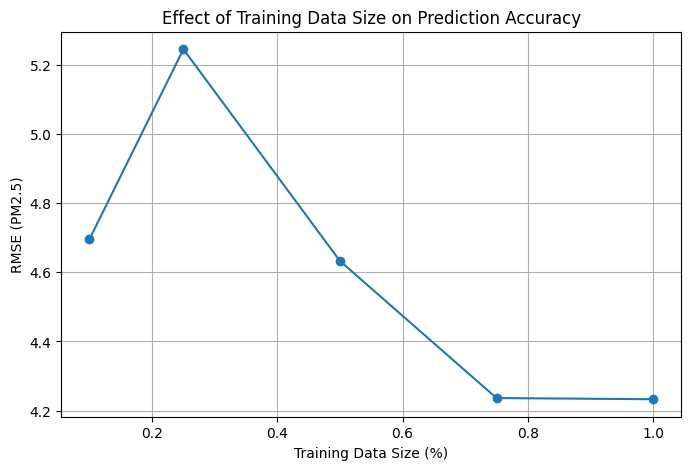

In [32]:
# Define different training data proportions
train_sizes = [0.1, 0.25, 0.5, 0.75, 1.0]
errors = []

# initialize datasets
choosen_features = [Item.PM2_5, Item.PM10, Item.NO2, Item.CO]   # using features that are highly correlated to value of PM2.5

train_dataset = PM2_5('train')
test_dataset = PM2_5('test')
X_train, y_train = train_dataset.pred_by_features(choosen_features)
X_test = test_dataset.pred_by_features(choosen_features)

X_train = np.delete(X_train, np.s_[0], axis=0)
y_train = np.delete(y_train, np.s_[0], axis=0)
X_test = np.delete(X_test, np.s_[0], axis=0)

n_train, dim1, dim2 = X_train.shape
n_test, dim1, dim2 = X_test.shape

X_train = X_train.reshape(n_train * dim1, dim2)
y_train = y_train.reshape(n_train * dim1)
X_test = X_test.reshape(n_test * dim1, dim2)

# start experiment
for size in train_sizes:
    subset_size = int(size * X_train.shape[0])
    X_sub, y_sub = X_train[:subset_size], y_train[:subset_size]
    
    model = LinearRegression(learning_rate=2e-5, n_iterations=10000)
    model.initialize()
    model.fit(X_sub, y_sub)
    
    y_pred_train = model.predict(X_sub)
    rmse = np.sqrt(np.mean((y_sub - y_pred_train) ** 2))
    errors.append(rmse)
    print(f'=> {int(size * 100)}% data size rmse: {rmse}\n')

    y_pred = model.predict(X_test)

    with open(f'submission_{int(size * 100)}.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['index', 'answer'])
        j = 0
        for i in range(choosen_features.index(Item.PM2_5), y_pred.shape[0], len(choosen_features)):
            writer.writerow([f'index_{j}', f'{y_pred[i]:.2f}'])
            j += 1 

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, errors, marker='o', linestyle='-')
plt.xlabel("Training Data Size (%)")
plt.ylabel("RMSE (PM2.5)")
plt.title("Effect of Training Data Size on Prediction Accuracy")
plt.grid()
plt.show()


### Effect of L2 Regularization on PM2.5 Prediction

/tmp/ipykernel_889965/1850177894.py:26: RuntimeWarning: Mean of empty slice
  self.nparray[i][j] = np.nanmean(self.nparray[i])
/tmp/ipykernel_889965/1850177894.py:26: RuntimeWarning: Mean of empty slice
  self.nparray[i][j] = np.nanmean(self.nparray[i])
100%|██████████| 10000/10000 [00:01<00:00, 5008.90it/s]


=> L2 regularization alpha=0 rmse: 4.233001965598413



100%|██████████| 10000/10000 [00:02<00:00, 4533.38it/s]


=> L2 regularization alpha=0.001 rmse: 4.2330019657033375



100%|██████████| 10000/10000 [00:02<00:00, 4561.52it/s]


=> L2 regularization alpha=0.01 rmse: 4.233001966647662



100%|██████████| 10000/10000 [00:02<00:00, 4311.10it/s]


=> L2 regularization alpha=0.1 rmse: 4.233001976091099



100%|██████████| 10000/10000 [00:01<00:00, 5373.32it/s]


=> L2 regularization alpha=1 rmse: 4.233002070543921



100%|██████████| 10000/10000 [00:02<00:00, 4416.76it/s]


=> L2 regularization alpha=10 rmse: 4.233003016917359



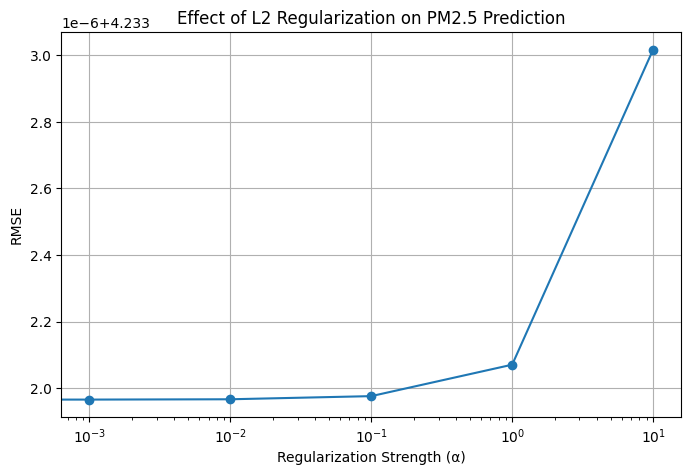

In [37]:
alpha_values = [0, 0.001, 0.01, 0.1, 1, 10]  # Regularization strengths
errors = []
save_name_list = ['NA','1e3', '1e2', '1e1', '1', '10']

# initialize datasets
choosen_features = [Item.PM2_5, Item.PM10, Item.NO2, Item.CO]   # using features that are highly correlated to value of PM2.5

train_dataset = PM2_5('train')
test_dataset = PM2_5('test')
X_train, y_train = train_dataset.pred_by_features(choosen_features)
X_test = test_dataset.pred_by_features(choosen_features)

X_train = np.delete(X_train, np.s_[0], axis=0)
y_train = np.delete(y_train, np.s_[0], axis=0)
X_test = np.delete(X_test, np.s_[0], axis=0)

n_train, dim1, dim2 = X_train.shape
n_test, dim1, dim2 = X_test.shape

X_train = X_train.reshape(n_train * dim1, dim2)
y_train = y_train.reshape(n_train * dim1)
X_test = X_test.reshape(n_test * dim1, dim2)

# start experiment
for alpha, save_name in zip(alpha_values, save_name_list):
    # start training
    model = LinearRegression(learning_rate=2e-5, n_iterations=10000, alpha=alpha)
    model.initialize()
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    rmse = np.sqrt(np.mean((y_train - y_pred_train) ** 2))
    errors.append(rmse)
    print(f'=> L2 regularization alpha={alpha} rmse: {rmse}\n')

    y_pred = model.predict(X_test)

    with open(f'submission_l2_{save_name}.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['index', 'answer'])
        j = 0
        for i in range(choosen_features.index(Item.PM2_5), y_pred.shape[0], len(choosen_features)):
            writer.writerow([f'index_{j}', f'{y_pred[i]:.2f}'])
            j += 1

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(alpha_values, errors, marker='o', linestyle='-')
plt.xscale("log")
plt.xlabel("Regularization Strength (α)")
plt.ylabel("RMSE")
plt.title("Effect of L2 Regularization on PM2.5 Prediction")
plt.grid()
plt.show()